In [1]:
import pandas as pd
import time
import random

from sklearn import preprocessing

from sklearn import metrics

from tqdm import tqdm
import apr_constants
import apr_functions_ul
import common_functions
import plot_functions

In [2]:
K_MEANS_METRICS_PARAMETERS = ['Compared_Genre', 'With_Correlation', 'Inertia', 'Homo', 'Compl', 'V-Meas', 'Ari', 'Ami', 'Silhouette', 'Clusters']
k_means_metrics = pd.DataFrame(columns=K_MEANS_METRICS_PARAMETERS)

FEATURES_FILE_NAME = '20MFCC_10000_10GEN_GTZAN.csv'
MFCCS_FOLDER = '20'

DATA_PATH = 'test_data/' + apr_constants.DATA
print('DATA_PATH: ', DATA_PATH)

SAVE_ROOT = 'test_data/' + apr_constants.ROOT_SAVE_PATH_NOTEBOOKS
print('SAVE_ROOT: ', SAVE_ROOT)
common_functions.check_create_directory(SAVE_ROOT)

SAVING_FILE_NAME = 'K_MEANS_METRICS_'+FEATURES_FILE_NAME

FEATURES_FILE_PATH = DATA_PATH+FEATURES_FILE_NAME
IMAGE_FILE_NAME = FEATURES_FILE_NAME.replace('.csv', '')

CLUSTERS_NUM = 2

permutations_to_eval = pd.DataFrame(apr_functions_ul.get_permutation(apr_constants.GENRE_TARGET_NAMES, 2), columns=['Compared_Genre','With_Correlation'])

DATA_PATH:  test_data/Data/
SAVE_ROOT:  test_data/Notebooks_Results/


In [3]:
for i, row in tqdm(permutations_to_eval.iterrows(), total=len(permutations_to_eval.index)):
  start_time = time.time()

  temp_k_means_metrics = pd.DataFrame(columns=K_MEANS_METRICS_PARAMETERS)
  With_Correlation = False

  original_file = pd.read_csv(FEATURES_FILE_PATH)
  df = original_file.copy()

  compared_genre = []

  new_genre = row.to_list()[0]
  corr_info = row.to_list()[1]

  compared_genre.append(new_genre[0] + '-' + new_genre[1])

  df = df[(df["genre"] == new_genre[0]) | (df["genre"] == new_genre[1])]
  normalization = 'min_max'

  ord_enc = preprocessing.OrdinalEncoder()
  df['genre'] = ord_enc.fit_transform(df[['genre']])

  # Split df into x and Y
  target_col = 'genre'
  X = df.loc[:, df.columns != target_col]
  y = df.loc[:, target_col]

  x_cols = X.columns
  if normalization == 'std':
      # NORMALIZE X WITH STANDARD SCALER #
      resized_data = preprocessing.StandardScaler()
      np_scaled = resized_data.fit_transform(X)
  elif normalization == 'min_max':
      # NORMALIZE X WITH Min Max SCALER #
      resized_data = preprocessing.MinMaxScaler()
      np_scaled = resized_data.fit_transform(X)
  elif normalization is None:
      np_scaled = X

  X = pd.DataFrame(np_scaled, columns=x_cols)
  y = pd.DataFrame(y).fillna(0).astype(int)

  if corr_info:
    # Get Correlation Matrix and Plot
    common_functions.getCorrelatedFeatures(X, 0.8, True, False, False, IMAGE_FILE_NAME)
    With_Correlation = True

  # Get K-means results
  labels, predict_clusters, centroids, k_means = apr_functions_ul.run_kmeans(X, CLUSTERS_NUM, 42, save_model=False)

  temp_k_means_metrics['Compared_Genre'] = compared_genre
  temp_k_means_metrics['With_Correlation'] = With_Correlation
  temp_k_means_metrics['Inertia'] = k_means.inertia_
  temp_k_means_metrics['Homo'] = metrics.homogeneity_score(y.genre, predict_clusters)
  temp_k_means_metrics['Compl'] = metrics.completeness_score(y.genre, predict_clusters)
  temp_k_means_metrics['V-Meas'] = metrics.v_measure_score(y.genre, predict_clusters)
  temp_k_means_metrics['Ari'] = metrics.adjusted_rand_score(y.genre, predict_clusters)
  temp_k_means_metrics['Ami'] = metrics.adjusted_mutual_info_score(y.genre, predict_clusters)
  temp_k_means_metrics['Silhouette'] = metrics.silhouette_score(X, predict_clusters, metric='euclidean')
  temp_k_means_metrics['Clusters'] = CLUSTERS_NUM

  k_means_metrics = k_means_metrics.append(temp_k_means_metrics, ignore_index = True)

k_means_metrics.to_csv(SAVE_ROOT+SAVING_FILE_NAME, index=False)
executionTime = time.time() - start_time
print()
print('Save CSV!')
print('Execution Time: ', "{:.2f}".format(executionTime) + ' sec')

100%|██████████| 90/90 [00:32<00:00,  2.78it/s]


Save CSV!
Execution Time:  0.38 sec


In [4]:
k_means_metrics.head()

,Compared_Genre,With_Correlation,Inertia,Homo,Compl,V-Meas,Ari,Ami,Silhouette,Clusters
0,blues-classical,False,600.575064,0.228999,0.246485,0.237421,0.262836,0.237135,0.308635,2
1,blues-classical,True,379.392552,0.244336,0.272340,0.257579,0.260803,0.257297,0.248587,2
2,blues-country,False,590.554484,0.001161,0.001165,0.001163,0.001103,0.000802,0.260780,2
3,blues-country,True,385.724367,0.003985,0.004007,0.003996,0.004982,0.003635,0.204786,2
4,blues-disco,False,499.702943,0.272904,0.303991,0.287610,0.286989,0.287338,0.337440,2


In [5]:
k_means_metrics.sort_values(['Silhouette'], ascending=False).head(n=1)

,Compared_Genre,With_Correlation,Inertia,Homo,Compl,V-Meas,Ari,Ami,Silhouette,Clusters
26,classical-metal,False,555.169757,0.821369,0.821902,0.821635,0.891082,0.821571,0.439355,2


In [6]:
test_best_sil_genre = k_means_metrics.sort_values(['Silhouette'], ascending=False, ignore_index=True).head(n=1)['Compared_Genre']
test_corr = k_means_metrics.sort_values(['Silhouette'], ascending=False).head(n=1)['With_Correlation']

In [7]:
test_best_sil_genre = test_best_sil_genre.to_string()
test_best_sil_genre = test_best_sil_genre.replace(' ', '')[1:len(test_best_sil_genre)].split('-')
print('test_best_sil_genre: ', test_best_sil_genre)
print('test_corr: ', test_corr.bool())

test_best_sil_genre:  ['classical', 'metal']
test_corr:  False


In [8]:
test_df = original_file.copy()
test_compared_genre = []

test_new_genre = test_best_sil_genre
test_corr_info = test_corr.bool()

test_compared_genre.append(test_new_genre[0] + '-' + test_new_genre[1])
test_df = test_df[(test_df["genre"] == test_new_genre[0]) | (test_df["genre"] == test_new_genre[1])]
normalization = 'min_max'

ord_enc = preprocessing.OrdinalEncoder()
test_df['genre'] = ord_enc.fit_transform(test_df[['genre']])

# Split df into x and Y
target_col = 'genre'
X_test = test_df.loc[:, test_df.columns != target_col]
y_test = test_df.loc[:, target_col]

x_test_cols = X_test.columns
if normalization == 'std':
    # NORMALIZE X_test WITH STANDARD SCALER #
    resized_data = preprocessing.StandardScaler()
    np_scaled = resized_data.fit_transform(X_test)
elif normalization == 'min_max':
    # NORMALIZE X_test WITH Min Max SCALER #
    resized_data = preprocessing.MinMaxScaler()
    np_scaled = resized_data.fit_transform(X_test)
elif normalization is None:
    np_scaled = X_test

X_test = pd.DataFrame(np_scaled, columns=x_test_cols)
y_test = pd.DataFrame(y_test)

if test_corr_info:
  # Get Correlation Matrix and Plot
  print('Correlation Drop Features')
  common_functions.getCorrelatedFeatures(X_test, 0.8, True, False, False, IMAGE_FILE_NAME)

first_occurrence_comp_spec_var:  5


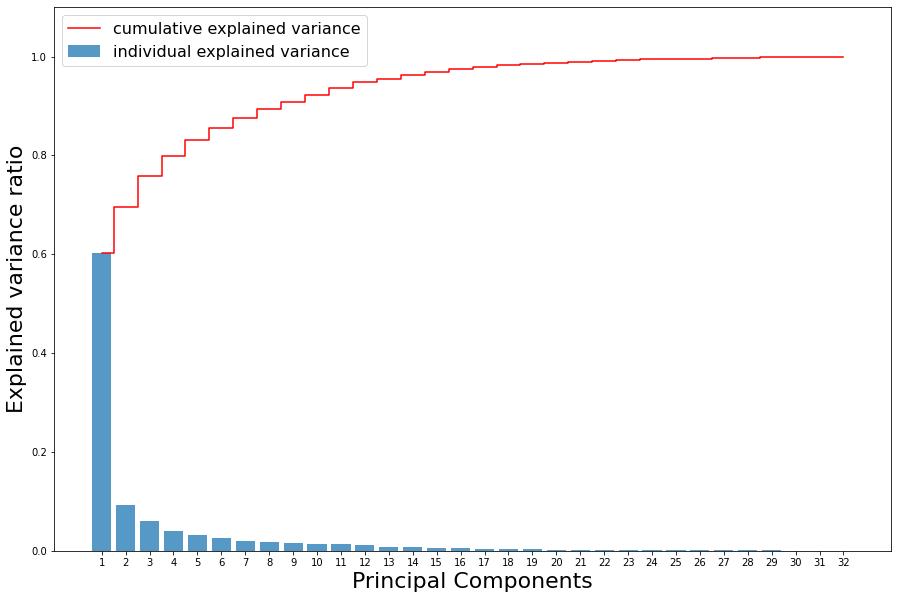

In [9]:
# Get PCA Variance Ratio
pca_components_to_use = apr_functions_ul.getPCA_VarRatio_Plot(X_test, 0.8, False, IMAGE_FILE_NAME)

In [10]:
# Get K-means results
labels_test, predict_clusters_test, centroids_test, k_means_test = apr_functions_ul.run_kmeans(X_test, CLUSTERS_NUM, 42, save_model=False)

PCA Variance Ratio For 5 Components: 0.8306934779926691
Save PCA Plot


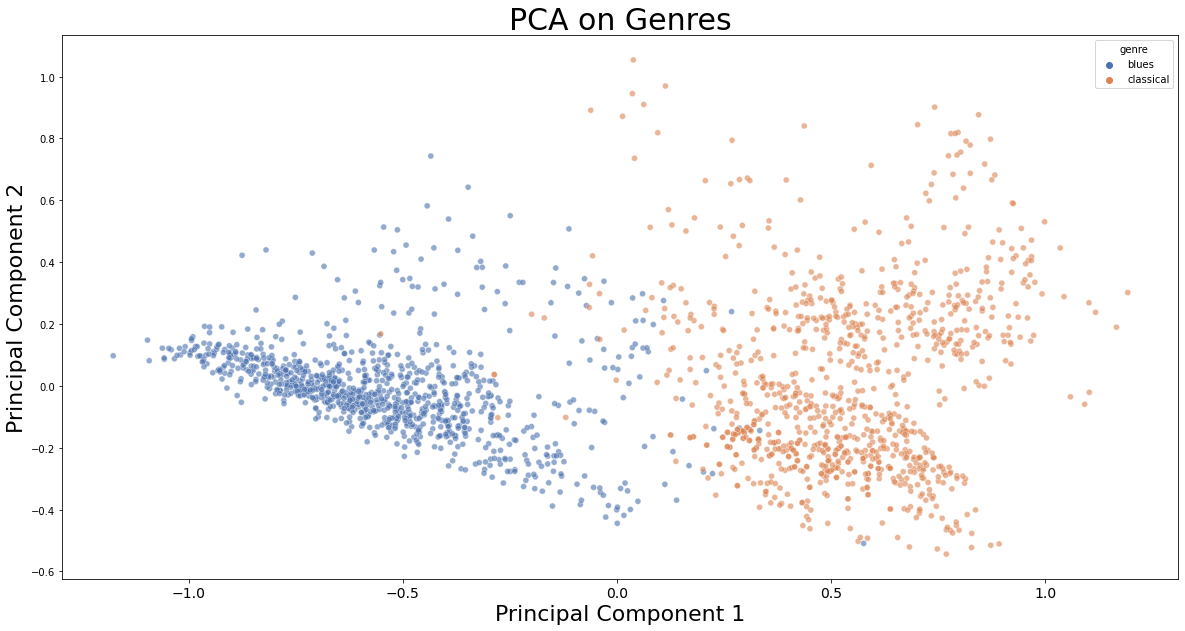

In [11]:
# Get PCA and Plot
pca_data_test, pca_centroids_test = apr_functions_ul.getPCAWithCentroids(X_test, y_test, pca_components_to_use, True, '2D', True,
                                                        apr_constants.GENRE_TARGET_NAMES, IMAGE_FILE_NAME,
                                                        SAVE_ROOT,
                                                        centroids_test)

Save Clusters Plot


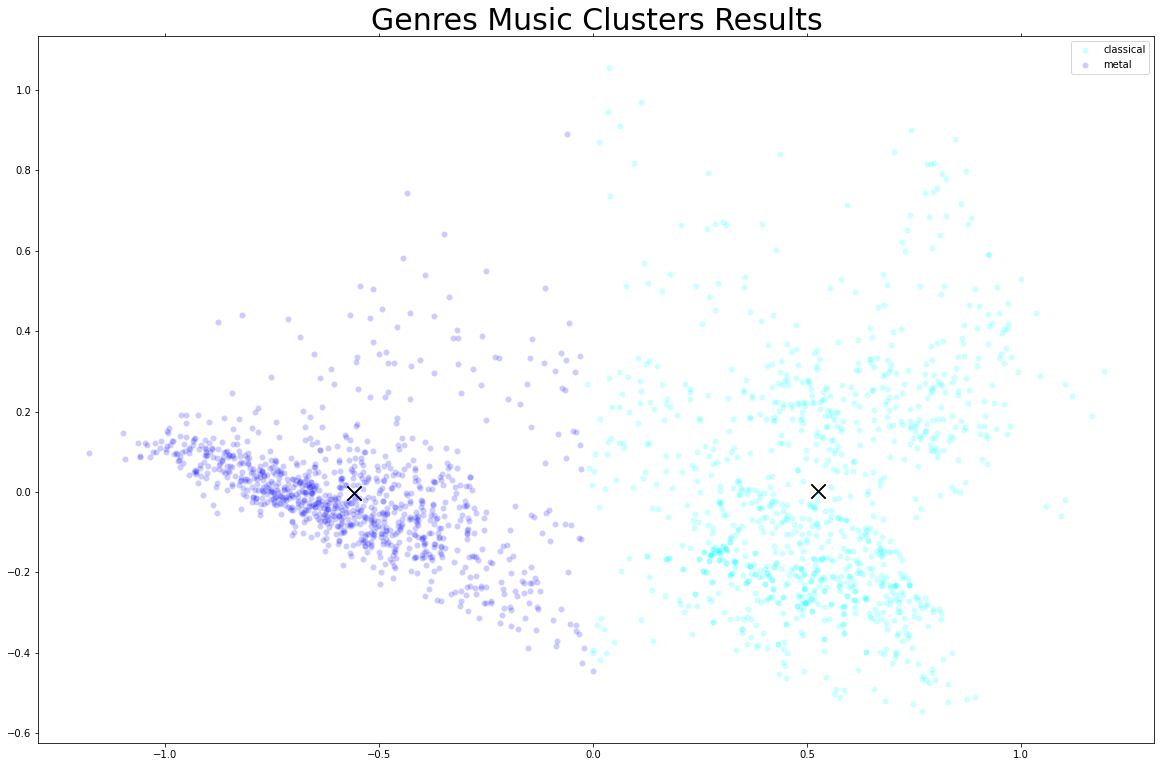

In [12]:
# Get Clusters Plot
plot_functions.plot_Clusters(pca_data_test, pca_centroids_test, labels_test, random.sample(apr_constants.COLORS_LIST, len(test_new_genre)), test_new_genre, True, True, IMAGE_FILE_NAME, SAVE_ROOT)

Save K-means Confusion Matrix


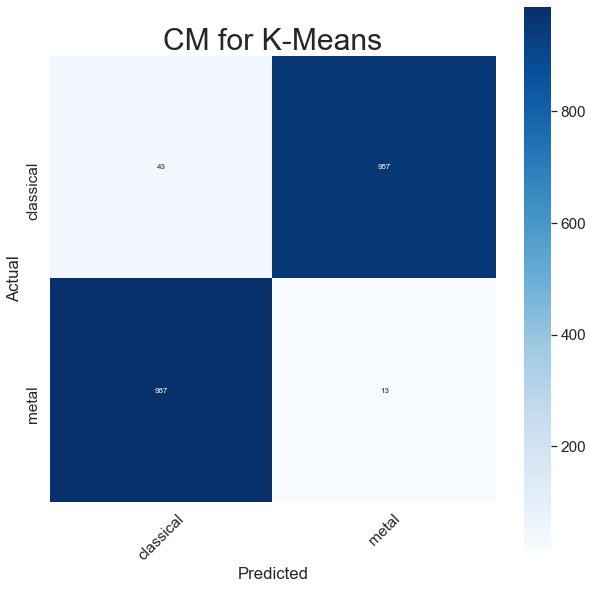

In [13]:
# Get K-means Confusion Matrix Plot
plot_functions.plot_confusion_matrix_kmeans(pca_data_test, True, labels_test, test_new_genre, IMAGE_FILE_NAME, SAVE_ROOT)

Save Silhouette Plot


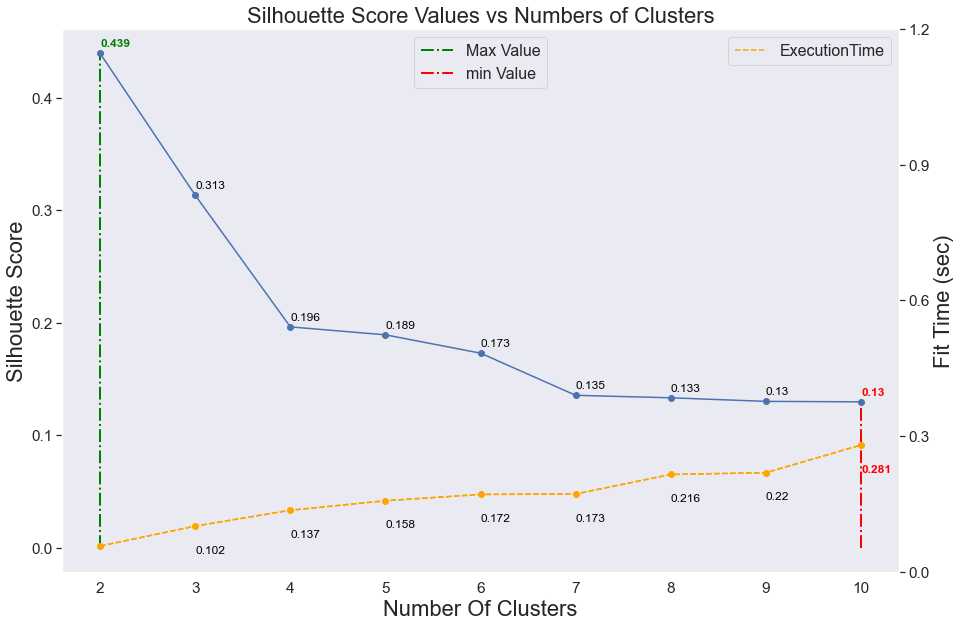

In [14]:
# Get Silhouette Plot
plot_functions.plot_Silhouette(X_test, 2, 10, True, IMAGE_FILE_NAME, SAVE_ROOT)